<h1><center>BBM469 - Assignment 3 : Machine Learning with Spark</center></h1> 

#### Group Number: 8

<br>

#### Student No : 21827775             
#### Student Name : Ali Argun Sayılgan

<br>

#### Student No : 21827723             
#### Student Name : Cihad Özcan

<h2><center>Task 1: Word Count</center></h2> 

## Table of Content

[Purpose](#purpose_task1)   
[Data Understanding](#data_understanding_task1)   
[Data Preparation](#data_preparation_task1)   
[Counting Words](#counting_words)  
[Evaluation](#evaluation_task1)  
[References](#references_task1)   

## Purpose <a class="anchor" id="purpose_task1"></a>

The main aim of this assignment is getting familiar with the basics of Apache Spark and machine learning methods using Spark Environment.

In order to accomplish that, for this task, we are expected to install Apache Spark and implement a simple <i>word count<i/> application

## Data Understanding<a class="anchor" id="data_understanding"></a>

In order to accomplish a <i>word count<i/> implementation, we downloaded and used <i>"The Complete Works in Philosophy, Politics and Morals of the late Dr. Benjamin"<i/> from the <i>Project Gutenberg<i/> [1]

In [1]:
import numpy as np
from pyspark import SparkContext, SparkConf
from pyspark.sql.session import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import col,isnan, when, count

# spark.conf.set("spark.sql.debug.maxToStringFields",100)
# spark.conf.set("spark.sql.shuffle.partitions",500)

# Create a baseRDD from the file path
baseRDD = sc.textFile("./Data/Benjamin_Franlin.txt")

# Split the lines of baseRDD into words
splitRDD = baseRDD.flatMap(lambda x: x.split())

# Count the total number of words
print("Total number of words in dataset:", splitRDD.count())

Total number of words in dataset: 473227


## Data Preparation<a class="anchor" id="data_preparation"></a>

In [2]:
from string import punctuation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Remove punctuation and convert numbers to spaces
nonPunctuatedRDD = baseRDD.map(lambda x: x.translate(x.maketrans('0123456789', '          ', punctuation)))

# Split the lines of baseRDD into words
splitRDD = nonPunctuatedRDD.flatMap(lambda x: x.split())

# Remove words shorter than 3 characters
longWordsRDD = splitRDD.filter(lambda x: len(x) > 2)

# Convert the words to lower case 
splitRDD_no_stop = longWordsRDD.map(lambda x: x.lower())

# Remove stop words from the stop_words curated list
additional_stop_words = {'did', 'does', 'iii'}
stop_words = set(ENGLISH_STOP_WORDS).union(additional_stop_words)
splitRDD_no_stop = splitRDD_no_stop.filter(lambda x: x not in stop_words)


# Count the total number of words
print("Total number of words in dataset after preprocessing:", splitRDD_no_stop.count())


Total number of words in dataset after preprocessing: 189293


## Counting Words<a class="anchor" id="counting_words"></a>

In [3]:
# Create a tuple of the word and 1 
splitRDD_no_stop_words = splitRDD_no_stop.map(lambda w: (w, 1))
total_occurences = splitRDD_no_stop.count()

# Count of the number of occurences of each word
resultRDD = splitRDD_no_stop_words.reduceByKey(lambda x, y: x + y)

## Evaluation<a class="anchor" id="evaluation"></a>

In [4]:
# Swap the keys and values from the input RDD, in order to use occurences as keys
resultRDD_swap = resultRDD.map(lambda x: (x[1], x[0]))

# Sort the keys in descending order
resultRDD_swap_sort = resultRDD_swap.sortByKey(ascending=False)

# Change order of pairs
resultRDD = resultRDD_swap_sort.map(lambda x: (x[1], x[0]))


# Show the top 150 most frequent words and their occurences from the sorted RDD
for word in resultRDD.take(150):
	print("{}: {}". format(word[0], word[1]))

air: 1073
great: 895
water: 879
time: 802
franklin: 655
america: 624
people: 608
little: 567
new: 546
make: 546
colonies: 533
good: 452
think: 432
glass: 427
shall: 416
country: 402
electricity: 399
electrical: 394
small: 393
long: 391
having: 378
letter: 367
end: 366
said: 358
england: 356
state: 352
quantity: 352
general: 352
common: 350
fluid: 336
body: 335
use: 334
electric: 325
place: 321
till: 320
lightning: 319
government: 310
wire: 310
present: 308
near: 306
sea: 302
house: 300
experiment: 298
power: 296
years: 295
britain: 294
force: 294
project: 293
account: 293
public: 292
man: 291
money: 290
work: 287
trade: 286
different: 285
governor: 285
means: 282
surface: 281
experiments: 277
act: 274
assembly: 270
number: 266
know: 264
matter: 263
paper: 263
parts: 261
greater: 258
men: 257
distance: 255
philadelphia: 249
earth: 249
room: 247
large: 246
right: 245
cold: 245
let: 244
manner: 241
necessary: 240
effect: 237
like: 234
case: 234
conductor: 230
given: 228
way: 226
soon: 221

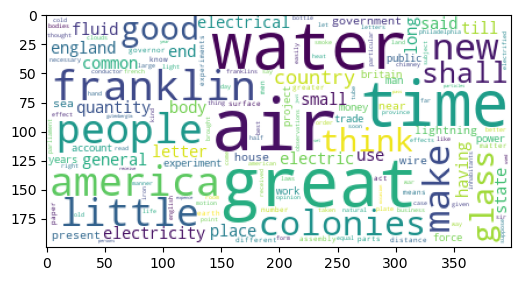

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
from wordcloud import WordCloud
from collections import ChainMap
import pyspark.sql.functions as F

resultRDD_limited = resultRDD.take(150)
df = spark.createDataFrame(resultRDD_limited, schema=['word', 'count'])

wordcloud = WordCloud(background_color="white")

words = dict(ChainMap(*df.select(F.create_map('word', 'count')).rdd.map(lambda x: x[0]).collect()))

plt.imshow(wordcloud.generate_from_frequencies(words))

plt.show()

## References<a class="anchor" id="references"></a>

[1] The Complete Works in Philosophy, Politics and Morals of the late Dr. Benjamin - Project Gutenberg, https://www.gutenberg.org/ebooks/search/?query=The+Complete+Works+in+Philosophy%2C+Politics+and+Morals+of+the+late+Dr.+Benjamin&submit_search=Go%21
    <br>

<h2><center>Task 2: Bean Type Classification</center></h2> 

## Table of Content

[Purpose](#purpose)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Clustering](#clusteringmodel)  
[Clustering results](#clustering)    
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


## Purpose <a class="anchor" id="purpose"></a>

The main aim of this assignment is getting familiar with the basics of Apache Spark and machine learning methods using Spark Environment. 

In order to accomplish that, we are given a set of features extracted from the shape of the beans in images and it's expected to predict the type of each bean. There are 7 bean types in the dataset.

## Data Understanding<a class="anchor" id="data_understanding"></a>

There are 13.611 observations in dataset, but 68 of them were duplicates and we removed them. 

Dataset involves 16 features and they are all numeric. Observations are labeled with one of seven classes which corresponds to bean types. There is no missing data in the dataset.


In [3]:
import numpy as np
from pyspark import SparkContext, SparkConf
from pyspark.sql.session import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import col,isnan, when, count

spark.conf.set("spark.sql.debug.maxToStringFields",100)
spark.conf.set("spark.sql.shuffle.partitions",500)

original_df = spark.read.csv("./Data/data.csv", header=True, inferSchema=True)

original_df_no_dup = original_df.dropDuplicates()
print('Total number of rows is {}, while {} is left after dropping {} duplicates.'.format(original_df.count(), original_df_no_dup.count(), original_df.count() - original_df_no_dup.count()))



Total number of rows is 13611, while 13543 is left after dropping 68 duplicates.


In [4]:
original_df_no_dup.printSchema()

root
 |-- Area: integer (nullable = true)
 |-- Perimeter: double (nullable = true)
 |-- MajorAxisLength: double (nullable = true)
 |-- MinorAxisLength: double (nullable = true)
 |-- AspectRation: double (nullable = true)
 |-- Eccentricity: double (nullable = true)
 |-- ConvexArea: integer (nullable = true)
 |-- EquivDiameter: double (nullable = true)
 |-- Extent: double (nullable = true)
 |-- Solidity: double (nullable = true)
 |-- roundness: double (nullable = true)
 |-- Compactness: double (nullable = true)
 |-- ShapeFactor1: double (nullable = true)
 |-- ShapeFactor2: double (nullable = true)
 |-- ShapeFactor3: double (nullable = true)
 |-- ShapeFactor4: double (nullable = true)
 |-- Class: string (nullable = true)



In [11]:
list_of_cols = original_df_no_dup.columns
for column in list_of_cols:
    if isinstance(original_df_no_dup.schema[column].dataType, StringType):
        continue
    print('Details for "{}" column:'.format(column))
    original_df_no_dup.describe(column).show()

Details for "Area" column:
+-------+------------------+
|summary|              Area|
+-------+------------------+
|  count|             13543|
|   mean| 53048.46038543897|
| stddev|29392.438324136998|
|    min|             20420|
|    max|            254616|
+-------+------------------+

Details for "Perimeter" column:
+-------+-----------------+
|summary|        Perimeter|
+-------+-----------------+
|  count|            13543|
|   mean|854.9934058923425|
| stddev|214.7226835430482|
|    min|          524.736|
|    max|          1985.37|
+-------+-----------------+

Details for "MajorAxisLength" column:
+-------+------------------+
|summary|   MajorAxisLength|
+-------+------------------+
|  count|             13543|
|   mean|319.89560224022154|
| stddev|  85.8092600339079|
|    min|        183.601165|
|    max|       738.8601535|
+-------+------------------+

Details for "MinorAxisLength" column:
+-------+------------------+
|summary|   MinorAxisLength|
+-------+------------------+
|

In [12]:
# Find columnwise count for empty, None, Null, Nan values [1]
missing_counts = original_df_no_dup.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c)).alias(c) for c in original_df_no_dup.columns])
missing_counts.show()

+----+---------+---------------+---------------+------------+------------+----------+-------------+------+--------+---------+-----------+------------+------------+------------+------------+-----+
|Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|Extent|Solidity|roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+----+---------+---------------+---------------+------------+------------+----------+-------------+------+--------+---------+-----------+------------+------------+------------+------------+-----+
|   0|        0|              0|              0|           0|           0|         0|            0|     0|       0|        0|          0|           0|           0|           0|           0|    0|
+----+---------+---------------+---------------+------------+------------+----------+-------------+------+--------+---------+-----------+------------+------------+------------+------------+-----+



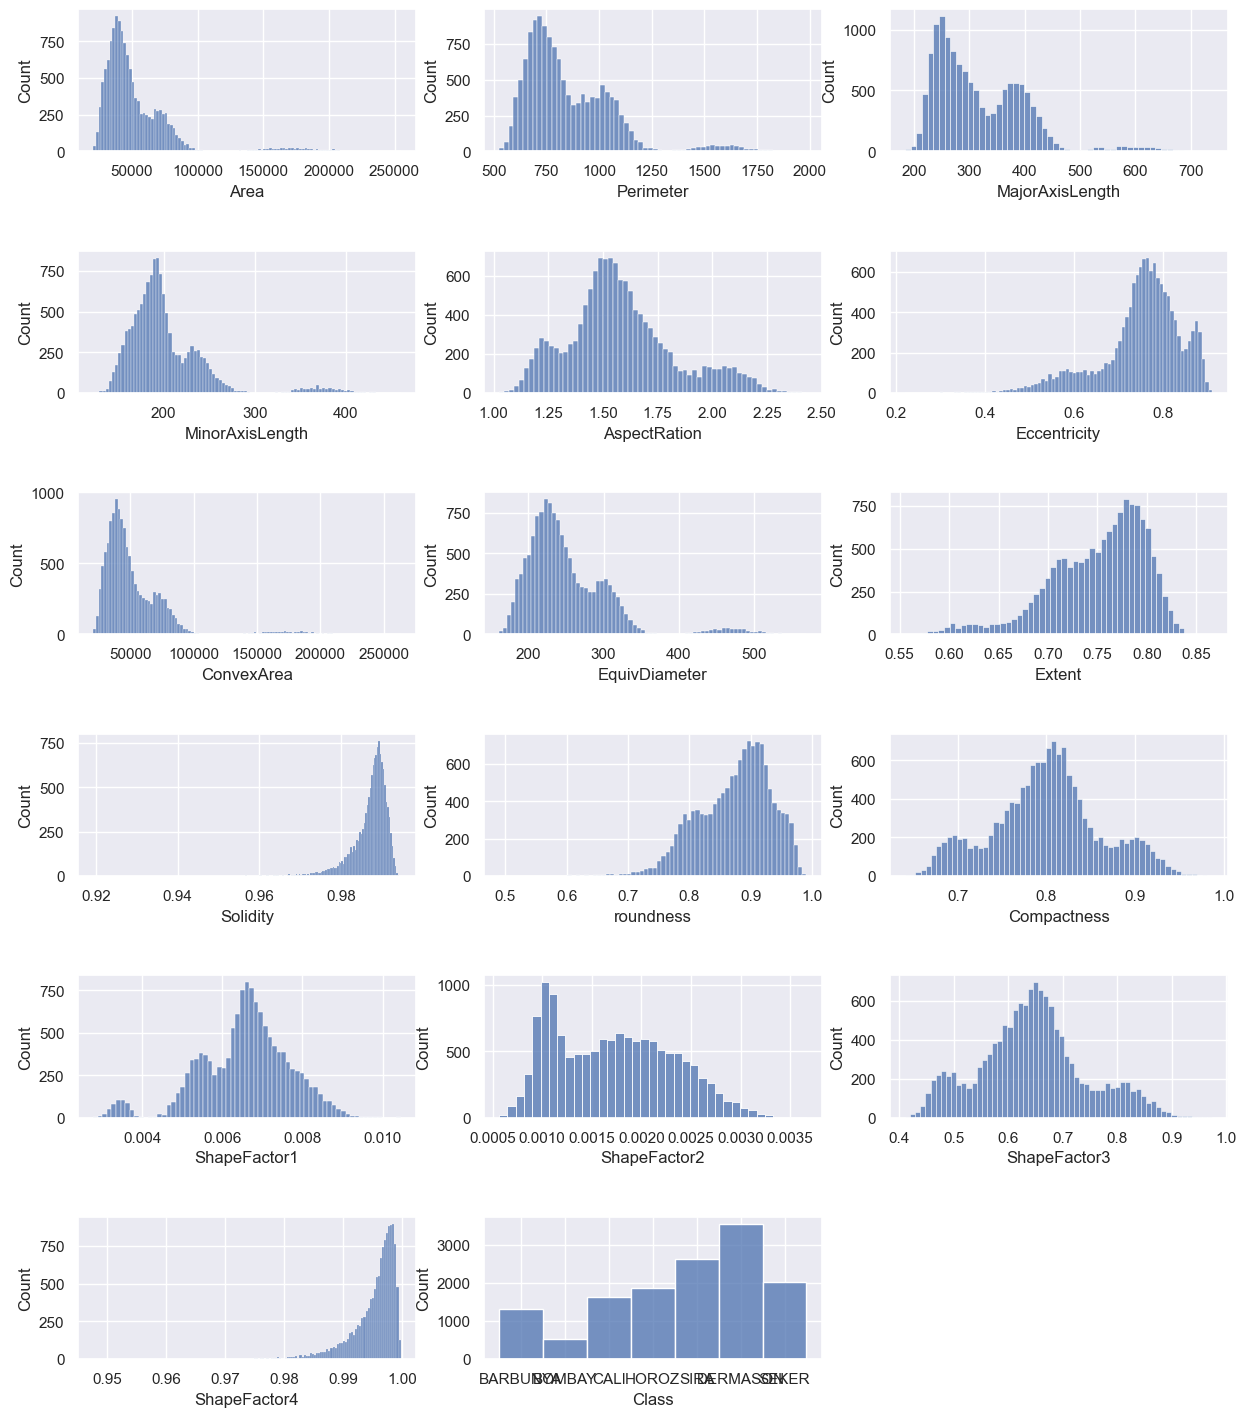

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
df_pandas = original_df_no_dup.toPandas()

###Histplot of each column to show distribution of the features over the dataset
for i, column in enumerate(df_pandas.columns, 1):
    plt.subplots_adjust(bottom=0.4, right=0.7, top=1.3, hspace = 0.7 )
    plt.subplot(6,3,i)
    sns.set(rc={'figure.figsize':(20,15)})
    sns.histplot(df_pandas[column])

## Data Preparation<a class="anchor" id="data_preparation"></a>

We used a pipeline that receives a list of transformations prepared with a list comprehension, to run MinMaxScaler on multiple columns [2]

In [5]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql import functions as f
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

OD = original_df_no_dup.cache()

# Scales numeric columns
columns_to_scale = OD.columns
columns_to_scale.remove("Class")
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(OD)
scaledData = scalerModel.transform(OD)

# Converts column type from vector to double type
convert_to_double = udf(lambda x: float(list(x)[0]), DoubleType())
for column in columns_to_scale:
    scaled_column = column + "_scaled"
    scaledData = scaledData.withColumn(column, convert_to_double(scaled_column))

# Drops intermediary columns
all_original_columns = columns_to_scale + ["Class"]
ND = scaledData.select(all_original_columns)

## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>

The reason behind experimenting with Bisecting K-Means & Kmeans was because KMeans is relatively simple to implement, scales well to large data sets, works well with low dimensioned datasets, and guarantees convergence and we have the required cluster size beforehand, as it is set to the class size of the dataset(bean types) which is 7.

Bisecting K-Means Algorithm is a modification of the K-Means algorithm. It beats K-Means in entropy measurement and it can recognize clusters of any shape and size. Thus we wanted to give it a try

In [ ]:
corr_matrix = original_df_no_dup.toPandas().corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))

print("Top 40 correlated features")
print(sol[:40])

As can seen from the correlation list above, its worth trying PCA in order to achieve better clustering results.
We have tested Bi-secting KMeans and KMeans clustering methods with different number of components from Principal Component Analysis(PCA) in order to achieve better clustering scores.

In [ ]:
columnsToVectorize = original_df_no_dup.columns

columnsToVectorize.remove("Class")
assembler = VectorAssembler(inputCols=columnsToVectorize, outputCol='features')
vectorized_ND = assembler.transform(ND)
vectorized_OD = assembler.transform(OD)


from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA


evalSilhouette = ClusteringEvaluator(predictionCol="Cluster_index",
                           featuresCol="features",
                           metricName="silhouette",
                           distanceMeasure="squaredEuclidean")


bkm_algo = BisectingKMeans(featuresCol='pcaFeatures',predictionCol="Cluster_index", k=7, seed=55)
kmeans_algo = KMeans(featuresCol='pcaFeatures', predictionCol="Cluster_index",k=7, seed=55)

In [ ]:
### Running this takes long time, PCA with 13 components gives optimal result for this dataset in our experiments
### Thats why its set to 13

for i in range(13,14):
    pca = PCA(
        k = 13, 
        inputCol = 'features', 
        outputCol = 'pcaFeatures'
    ).fit(vectorized_ND)
    output = pca.transform(vectorized_ND)
    
    bkm_fit = bkm_algo.fit(output)
    km_fit = kmeans_algo.fit(output)

    outputBKM = bkm_fit.transform(output)
    outputKM = km_fit.transform(output)

    scoreBKM_ND = evalSilhouette.evaluate(outputBKM)
    scoreKM_ND = evalSilhouette.evaluate(outputKM)
    
    pca = PCA(
        k = i, 
        inputCol = 'features', 
        outputCol = 'pcaFeatures'
    ).fit(vectorized_OD)
    output = pca.transform(vectorized_OD)
    
    bkm_fit = bkm_algo.fit(output)
    km_fit = kmeans_algo.fit(output)

    outputBKM = bkm_fit.transform(output)
    outputKM = km_fit.transform(output)

    scoreBKM_OD = evalSilhouette.evaluate(outputBKM)
    scoreKM_OD = evalSilhouette.evaluate(outputKM)
    
    print("PCA("+str(i)+")")
    print("BisectingKMeans silhouette score:\tND | OD  ",scoreBKM_ND,"\t|",scoreBKM_OD)
    print("KMeans silhouette score:\t\tND | OD  ",scoreKM,"\t|",scoreKM_OD)
    print("----------------------")

## Clustering results<a class="anchor" id="clustering"></a>

PCA didn't effect the silhouette score much.
Surprisingly, OD(non-normalized dataset) got significantly higher silhouette scores but this doesn't mean much. When we consider the cluster distribution visualy and compare OD-ND, real clustering performance can be seen.


In [ ]:
ndd = ND
odd = OD

#### Changing class names to indexes
from pyspark.ml.feature import StringIndexer

strIndexer = StringIndexer(inputCol = 'Class', outputCol = 'ClassIndex')

indexModel = strIndexer.fit(ndd)
ndd = indexModel.transform(ndd)

indexModel = strIndexer.fit(odd)
odd = indexModel.transform(odd)



###Converting ClassIndex from string to int
from pyspark.sql.types import IntegerType
ndd = ndd.withColumn("ClassIndex", ndd["ClassIndex"].cast(IntegerType()))
ndd = ndd.drop("Class")

odd = odd.withColumn("ClassIndex", odd["ClassIndex"].cast(IntegerType()))
odd = odd.drop("Class")

ndd.printSchema()

In [ ]:
assembler = VectorAssembler(inputCols=columnsToVectorize, outputCol='features')
vectorized_ndd = assembler.transform(ndd)
kmeans_algo = KMeans(featuresCol='features', predictionCol="Cluster_index",k=7, seed=55)
kmModel = kmeans_algo.fit(vectorized_ndd)
ndd_clustered = kmModel.transform(vectorized_ndd)

In [ ]:
assembler = VectorAssembler(inputCols=columnsToVectorize, outputCol='features')
vectorized_odd = assembler.transform(odd)
kmeans_algo = KMeans(featuresCol='features', predictionCol="Cluster_index",k=7, seed=55)
kmModel = kmeans_algo.fit(vectorized_odd)
odd_clustered = kmModel.transform(vectorized_odd)

# ND Class/Cluster distribution respectively

In [ ]:
!pip install plotly==5.7.0
import plotly.express as px
colors = ['#550000', '#BB0000', '#FF0000', '#EEEE00', '#00FF00', '#00BB00', '#005500']
px.scatter(ND.toPandas(),hover_name="Class",template='plotly_dark',
           x="MajorAxisLength",y="MinorAxisLength",color="Class",symbol="Class",color_discrete_sequence=colors, title="ND - Class distribution")

In [ ]:
px.scatter(ndd_clustered.toPandas(),hover_name="Cluster_index",template='plotly_dark',
           x="MajorAxisLength",y="MinorAxisLength",color="Cluster_index",color_discrete_sequence=colors, title="ND - Cluster Distribution")

# OD Class/Cluster distribution respectively

In [ ]:
px.scatter(OD.toPandas(),hover_name="Class",template='plotly_dark',
           x="MajorAxisLength",y="MinorAxisLength",color="Class",symbol="Class",color_discrete_sequence=colors, title="OD - Class distribution")

In [ ]:
px.scatter(odd_clustered.toPandas(),hover_name="Cluster_index",template='plotly_dark',
           x="MajorAxisLength",y="MinorAxisLength",color="Cluster_index",color_discrete_sequence=colors, title="OD - Cluster Distribution")


## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

In [6]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

features = ND.columns
features.remove("Class")

stages = []

stringIndexer = StringIndexer(inputCol = 'Class', outputCol = 'ClassIndex')
encoder = OneHotEncoder(inputCols=['ClassIndex'], outputCols=["ClassVec"])
stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'Class', outputCol = 'label')
stages += [label_stringIdx]

assembler = VectorAssembler(inputCols=features, outputCol="features")
stages += [assembler]

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(ND)
ND = pipelineModel.transform(ND)
selectedCols = ['Class', 'label', 'features']
ND = ND.select(selectedCols).cache()


In [22]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix

train, test = ND.randomSplit([0.8, 0.2], seed = 33)
sqlContext.clearCache()
train.cache()
test.cache()

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', probabilityCol='probability', rawPredictionCol='rawPrediction', maxMemoryInMB=1024)


paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [3, 5, 7])
             .addGrid(rf.maxBins, [20, 32, 45])
             .addGrid(rf.numTrees, [10, 20, 30])
             .build())


evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")


cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)

print("Accuracy: ", evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print("Precision: ", evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel"}))
print("Recall: ", evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"}))
print("F1-score: ", evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

y_pred = predictions.select("prediction").collect()
y_orig = predictions.select("label").collect()
cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)


22/04/19 19:33:14 WARN DAGScheduler: Broadcasting large task binary with size 1014.7 KiB
22/04/19 19:34:49 WARN DAGScheduler: Broadcasting large task binary with size 1228.7 KiB
22/04/19 19:35:12 WARN DAGScheduler: Broadcasting large task binary with size 1156.1 KiB
22/04/19 19:38:33 WARN DAGScheduler: Broadcasting large task binary with size 1181.3 KiB
22/04/19 19:38:58 WARN DAGScheduler: Broadcasting large task binary with size 1129.2 KiB
22/04/19 19:41:02 WARN DAGScheduler: Broadcasting large task binary with size 1012.1 KiB
22/04/19 19:42:28 WARN DAGScheduler: Broadcasting large task binary with size 1218.8 KiB
22/04/19 19:42:54 WARN DAGScheduler: Broadcasting large task binary with size 1173.0 KiB
22/04/19 19:52:10 WARN DAGScheduler: Broadcasting large task binary with size 1018.7 KiB
22/04/19 19:53:24 WARN DAGScheduler: Broadcasting large task binary with size 1231.2 KiB
22/04/19 19:53:41 WARN DAGScheduler: Broadcasting large task binary with size 1165.8 KiB
22/04/19 19:55:12 WAR

Accuracy:  0.9004774146162321


Precision:  0.9059474412171508


Recall:  0.9059474412171508


F1-score:  0.9008851341080488


Confusion Matrix:
[[655  56   9   3   0   0   0]
 [ 54 461   7   4   3   0   0]
 [ 11  11 377   0   0   2   0]
 [  3  19   0 333  11   2   0]
 [  0   7   0   3 302  18   5]
 [  0   7   1   1  34 221   0]
 [  0   0   0   0   0   0 103]]


In [23]:
bestModel = cvModel.bestModel
print('Best Param (maxDepth): ', bestModel._java_obj.getMaxDepth())

print('Best Param (maxBins): ', bestModel._java_obj.getMaxBins())

print('Best Param (numTrees): ', bestModel._java_obj.getNumTrees())

Best Param (maxDepth):  7
Best Param (maxBins):  20
Best Param (numTrees):  20


In [10]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix

ND=ND.repartition(500).cache()
OD=OD.repartition(500).cache()
train, test = ND.randomSplit([0.8, 0.2], seed = 33)
sqlContext.clearCache()
train.cache()
test.cache()

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', probabilityCol='probability', rawPredictionCol='rawPrediction', maxMemoryInMB=1024, maxBins=20, maxDepth=7, numTrees=30)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print("Metrics for ND:")
print("Accuracy: ", evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print("Precision: ", evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel"}))
print("Recall: ", evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"}))
print("F1-score: ", evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

y_pred = predictions.select("prediction").collect()
y_orig = predictions.select("label").collect()
cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)


Metrics for ND:


Accuracy:  0.9107011070110701


Precision:  0.9134078212290503


Recall:  0.9276595744680851


F1-score:  0.9109732510342698


Confusion Matrix:
[[654  40  11   0   0   0   0]
 [ 53 460   5   6   0   1   0]
 [  7  19 379   0   0   3   0]
 [  2  13   0 350  16   1   0]
 [  0   2   0   0 312  20   4]
 [  0  11   1   0  26 208   1]
 [  0   0   0   0   0   0 105]]


In [7]:
features = OD.columns
features.remove("Class")

stages = []

stringIndexer = StringIndexer(inputCol = 'Class', outputCol = 'ClassIndex')
encoder = OneHotEncoder(inputCols=['ClassIndex'], outputCols=["ClassVec"])
stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'Class', outputCol = 'label')
stages += [label_stringIdx]

assembler = VectorAssembler(inputCols=features, outputCol="features")
stages += [assembler]

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(OD)
OD = pipelineModel.transform(OD)
selectedCols = ['Class', 'label', 'features']
OD = OD.select(selectedCols).cache()


In [9]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix

OD=OD.repartition(500).cache()
train, test = OD.randomSplit([0.8, 0.2], seed = 33)
spark.catalog.clearCache()
train.cache()
test.cache()

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', probabilityCol='probability', rawPredictionCol='rawPrediction', maxMemoryInMB=1024, maxBins=20, maxDepth=7, numTrees=30)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print("Metrics for OD:")
print("Accuracy: ", evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print("Precision: ", evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel"}))
print("Recall: ", evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"}))
print("F1-score: ", evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

y_pred = predictions.select("prediction").collect()
y_orig = predictions.select("label").collect()
cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Metrics for OD:


Accuracy:  0.9029520295202952


Precision:  0.891156462585034


Recall:  0.9264497878359265


F1-score:  0.9031936405087813


Confusion Matrix:
[[655  43   9   0   0   0   0]
 [ 63 446   5   4   3   0   0]
 [ 13  21 390   0   0   2   0]
 [  4  17   0 339   7   3   0]
 [  0   1   1   5 306  16   3]
 [  0   9   2   0  28 225   4]
 [  0   0   0   0   0   0  86]]


## References<a class="anchor" id="references"></a>

[1] <i>Spark by {Examples}<i/>, https://sparkbyexamples.com/pyspark/pyspark-find-count-of-null-none-nan-values
    <br>
[2] <i>Stack Overflow - Apply MinMaxScaler on multiple columns in PySpark<i/>, https://stackoverflow.com/questions/60281354/apply-minmaxscaler-on-multiple-columns-in-pyspark


**Disclaimer!** <font color='grey'>This notebook was prepared by <student name(s)> as an assigment for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>